In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math

import pandas as pd
import numpy as np

import os

from utils.path_utils import project_root

import tqdm



In [10]:
import tqdm

# Gather sepsis details
file_path = os.path.join(project_root(), 'data', 'processed', 'is_sepsis.txt')
sepsis = pd.Series(open(file_path, 'r').read().splitlines()).astype(int)

# Collect all samples
csv_path = os.path.join(project_root(), 'data', 'csv')
training_files = [os.path.join(csv_path, f) for f in os.listdir(csv_path) if f.endswith('.csv')]
training_files.sort()

# Filtering only positive samples
positive_sepsis = sepsis[sepsis==1].index
negative_sepsis = sepsis[sepsis==0].index

# Filtered positive patients
training_files = [training_files[idx] for idx in positive_sepsis]

# File names 
file_names = [training_files[idx].split('/')[-1].replace('.csv', '.psv') for idx in range(len(training_files))]
file_names.sort()

# Converting them to psv files
destination_path = os.path.join(project_root(), 'data', 'test_data')
for i, (patient_data, file_name) in enumerate(
        tqdm.tqdm(zip(training_files, file_names), desc="Processing positive sepsis patients",
                  total=len(training_files))):
    patient_data = pd.read_csv(patient_data)
    patient_data = patient_data.drop(['PatientID', 'SepsisLabel'], axis=1)
    psv_file_name = file_name.split('/')[-1].replace('.csv', '.psv')
    print(file_name)
    
    # patient_data.to_csv(os.path.join(destination_path, psv_file_name), sep='|', index=False)


Processing positive sepsis patients:   5%|▍         | 144/2932 [00:00<00:03, 715.41it/s]

p000009.psv
p000011.psv
p000015.psv
p000018.psv
p000022.psv
p000028.psv
p000034.psv
p000042.psv
p000053.psv
p000056.psv
p000058.psv
p000063.psv
p000064.psv
p000078.psv
p000141.psv
p000161.psv
p000171.psv
p000178.psv
p000185.psv
p000188.psv
p000203.psv
p000206.psv
p000211.psv
p000226.psv
p000260.psv
p000265.psv
p000272.psv
p000283.psv
p000286.psv
p000311.psv
p000324.psv
p000346.psv
p000354.psv
p000357.psv
p000359.psv
p000371.psv
p000373.psv
p000376.psv
p000379.psv
p000384.psv
p000401.psv
p000403.psv
p000466.psv
p000468.psv
p000483.psv
p000524.psv
p000541.psv
p000545.psv
p000559.psv
p000574.psv
p000584.psv
p000587.psv
p000601.psv
p000614.psv
p000616.psv
p000635.psv
p000639.psv
p000650.psv
p000653.psv
p000654.psv
p000656.psv
p000674.psv
p000679.psv
p000698.psv
p000702.psv
p000705.psv
p000714.psv
p000728.psv
p000730.psv
p000754.psv
p000762.psv
p000765.psv
p000772.psv
p000784.psv
p000795.psv
p000811.psv
p000818.psv
p000847.psv
p000851.psv
p000872.psv
p000890.psv
p000897.psv
p000938.psv
p000

Processing positive sepsis patients:  10%|▉         | 290/2932 [00:00<00:03, 721.72it/s]

p001519.psv
p001523.psv
p001547.psv
p001588.psv
p001605.psv
p001610.psv
p001625.psv
p001635.psv
p001646.psv
p001666.psv
p001668.psv
p001669.psv
p001670.psv
p001698.psv
p001712.psv
p001717.psv
p001727.psv
p001744.psv
p001765.psv
p001771.psv
p001786.psv
p001793.psv
p001810.psv
p001811.psv
p001830.psv
p001834.psv
p001836.psv
p001839.psv
p001849.psv
p001861.psv
p001863.psv
p001873.psv
p001895.psv
p001912.psv
p001917.psv
p001932.psv
p001948.psv
p001954.psv
p001955.psv
p001993.psv
p002004.psv
p002027.psv
p002029.psv
p002034.psv
p002067.psv
p002080.psv
p002097.psv
p002099.psv
p002100.psv
p002114.psv
p002117.psv
p002125.psv
p002130.psv
p002131.psv
p002156.psv
p002161.psv
p002185.psv
p002188.psv
p002203.psv
p002211.psv
p002213.psv
p002220.psv
p002273.psv
p002292.psv
p002316.psv
p002321.psv
p002326.psv
p002332.psv
p002360.psv
p002399.psv
p002404.psv
p002425.psv
p002429.psv
p002441.psv
p002446.psv
p002519.psv
p002521.psv
p002525.psv
p002535.psv
p002541.psv
p002544.psv
p002546.psv
p002551.psv
p002

Processing positive sepsis patients:  12%|█▏        | 363/2932 [00:00<00:03, 723.36it/s]

p003204.psv
p003205.psv
p003227.psv
p003231.psv
p003233.psv
p003234.psv
p003246.psv
p003247.psv
p003273.psv
p003308.psv
p003321.psv
p003323.psv
p003325.psv
p003332.psv
p003373.psv
p003375.psv
p003377.psv
p003379.psv
p003390.psv
p003391.psv
p003407.psv
p003421.psv
p003427.psv
p003438.psv
p003449.psv
p003455.psv
p003457.psv
p003486.psv
p003488.psv
p003497.psv
p003523.psv
p003532.psv
p003539.psv
p003547.psv
p003567.psv
p003581.psv
p003592.psv
p003614.psv
p003634.psv
p003639.psv
p003645.psv
p003647.psv
p003648.psv
p003650.psv
p003657.psv
p003661.psv
p003665.psv
p003668.psv
p003685.psv
p003698.psv
p003708.psv
p003729.psv
p003732.psv
p003752.psv
p003768.psv
p003778.psv
p003791.psv
p003806.psv
p003809.psv
p003811.psv
p003831.psv
p003866.psv
p003889.psv
p003893.psv
p003920.psv
p003921.psv
p003936.psv
p003953.psv
p003959.psv
p004016.psv
p004019.psv
p004020.psv
p004023.psv
p004024.psv
p004030.psv
p004041.psv
p004069.psv
p004071.psv
p004123.psv
p004132.psv
p004139.psv
p004158.psv
p004162.psv
p004

Processing positive sepsis patients:  20%|█▉        | 583/2932 [00:00<00:03, 725.84it/s]

p004924.psv
p004928.psv
p004939.psv
p004941.psv
p004964.psv
p004966.psv
p004980.psv
p004982.psv
p004986.psv
p004988.psv
p005007.psv
p005026.psv
p005037.psv
p005038.psv
p005053.psv
p005079.psv
p005091.psv
p005092.psv
p005099.psv
p005112.psv
p005129.psv
p005154.psv
p005179.psv
p005186.psv
p005188.psv
p005191.psv
p005198.psv
p005211.psv
p005233.psv
p005234.psv
p005251.psv
p005259.psv
p005277.psv
p005294.psv
p005316.psv
p005317.psv
p005322.psv
p005325.psv
p005328.psv
p005338.psv
p005359.psv
p005386.psv
p005391.psv
p005394.psv
p005406.psv
p005416.psv
p005418.psv
p005425.psv
p005427.psv
p005429.psv
p005438.psv
p005457.psv
p005462.psv
p005500.psv
p005508.psv
p005511.psv
p005519.psv
p005533.psv
p005539.psv
p005545.psv
p005554.psv
p005566.psv
p005576.psv
p005600.psv
p005605.psv
p005610.psv
p005637.psv
p005642.psv
p005644.psv
p005651.psv
p005676.psv
p005677.psv
p005688.psv
p005691.psv
p005693.psv
p005702.psv
p005710.psv
p005714.psv
p005719.psv
p005728.psv
p005748.psv
p005751.psv
p005755.psv
p005

Processing positive sepsis patients:  22%|██▏       | 656/2932 [00:00<00:03, 723.27it/s]

p006617.psv
p006632.psv
p006639.psv
p006669.psv
p006673.psv
p006681.psv
p006700.psv
p006706.psv
p006737.psv
p006743.psv
p006765.psv
p006766.psv
p006770.psv
p006785.psv
p006787.psv
p006791.psv
p006833.psv
p006940.psv
p006967.psv
p006968.psv
p006984.psv
p006995.psv
p007001.psv
p007017.psv
p007018.psv
p007048.psv
p007070.psv
p007093.psv
p007128.psv
p007132.psv
p007140.psv
p007154.psv
p007168.psv
p007174.psv
p007186.psv
p007187.psv
p007194.psv
p007201.psv
p007240.psv
p007245.psv
p007252.psv
p007280.psv
p007283.psv
p007328.psv
p007348.psv
p007352.psv
p007382.psv
p007399.psv
p007411.psv
p007416.psv
p007417.psv
p007423.psv
p007456.psv
p007459.psv
p007472.psv
p007481.psv
p007492.psv
p007500.psv
p007510.psv
p007526.psv
p007538.psv
p007540.psv
p007552.psv
p007564.psv
p007577.psv
p007599.psv
p007603.psv
p007639.psv
p007646.psv
p007649.psv
p007676.psv
p007678.psv
p007694.psv
p007716.psv
p007717.psv
p007768.psv
p007770.psv
p007775.psv
p007802.psv
p007826.psv
p007836.psv
p007837.psv
p007857.psv
p007

Processing positive sepsis patients:  30%|██▉       | 875/2932 [00:01<00:02, 723.97it/s]

p008630.psv
p008634.psv
p008638.psv
p008640.psv
p008654.psv
p008658.psv
p008679.psv
p008680.psv
p008684.psv
p008697.psv
p008706.psv
p008710.psv
p008713.psv
p008727.psv
p008736.psv
p008737.psv
p008756.psv
p008772.psv
p008780.psv
p008781.psv
p008801.psv
p008802.psv
p008803.psv
p008811.psv
p008814.psv
p008852.psv
p008853.psv
p008861.psv
p008867.psv
p008873.psv
p008890.psv
p008907.psv
p008912.psv
p008927.psv
p008978.psv
p009000.psv
p009002.psv
p009008.psv
p009023.psv
p009030.psv
p009036.psv
p009038.psv
p009042.psv
p009051.psv
p009053.psv
p009057.psv
p009064.psv
p009092.psv
p009099.psv
p009115.psv
p009129.psv
p009139.psv
p009142.psv
p009145.psv
p009146.psv
p009167.psv
p009178.psv
p009197.psv
p009207.psv
p009214.psv
p009215.psv
p009245.psv
p009252.psv
p009259.psv
p009260.psv
p009277.psv
p009278.psv
p009313.psv
p009315.psv
p009322.psv
p009332.psv
p009334.psv
p009360.psv
p009361.psv
p009372.psv
p009393.psv
p009396.psv
p009398.psv
p009420.psv
p009433.psv
p009435.psv
p009441.psv
p009463.psv
p009

Processing positive sepsis patients:  35%|███▍      | 1021/2932 [00:01<00:02, 724.88it/s]

p010142.psv
p010156.psv
p010157.psv
p010161.psv
p010209.psv
p010211.psv
p010220.psv
p010236.psv
p010253.psv
p010262.psv
p010264.psv
p010280.psv
p010289.psv
p010308.psv
p010339.psv
p010349.psv
p010355.psv
p010377.psv
p010387.psv
p010389.psv
p010416.psv
p010418.psv
p010427.psv
p010441.psv
p010461.psv
p010482.psv
p010490.psv
p010491.psv
p010497.psv
p010540.psv
p010549.psv
p010580.psv
p010606.psv
p010627.psv
p010628.psv
p010631.psv
p010634.psv
p010645.psv
p010652.psv
p010656.psv
p010664.psv
p010665.psv
p010682.psv
p010686.psv
p010700.psv
p010705.psv
p010710.psv
p010740.psv
p010741.psv
p010755.psv
p010756.psv
p010771.psv
p010778.psv
p010782.psv
p010804.psv
p010821.psv
p010829.psv
p010855.psv
p010876.psv
p010879.psv
p010880.psv
p010888.psv
p010924.psv
p010936.psv
p010948.psv
p010954.psv
p010957.psv
p010966.psv
p010974.psv
p010976.psv
p010983.psv
p010984.psv
p010992.psv
p010997.psv
p010998.psv
p011010.psv
p011056.psv
p011090.psv
p011093.psv
p011094.psv
p011105.psv
p011120.psv
p011132.psv
p011

Processing positive sepsis patients:  40%|███▉      | 1167/2932 [00:01<00:02, 724.18it/s]

p011876.psv
p011891.psv
p011898.psv
p011899.psv
p011901.psv
p011929.psv
p011932.psv
p011953.psv
p011966.psv
p011967.psv
p011980.psv
p011989.psv
p012023.psv
p012028.psv
p012042.psv
p012043.psv
p012057.psv
p012076.psv
p012091.psv
p012107.psv
p012116.psv
p012117.psv
p012123.psv
p012138.psv
p012141.psv
p012150.psv
p012171.psv
p012177.psv
p012194.psv
p012208.psv
p012210.psv
p012228.psv
p012233.psv
p012245.psv
p012269.psv
p012278.psv
p012293.psv
p012294.psv
p012303.psv
p012322.psv
p012332.psv
p012333.psv
p012341.psv
p012349.psv
p012352.psv
p012359.psv
p012373.psv
p012375.psv
p012391.psv
p012417.psv
p012459.psv
p012461.psv
p012465.psv
p012476.psv
p012485.psv
p012497.psv
p012506.psv
p012508.psv
p012513.psv
p012525.psv
p012529.psv
p012538.psv
p012541.psv
p012547.psv
p012562.psv
p012566.psv
p012567.psv
p012568.psv
p012570.psv
p012576.psv
p012590.psv
p012591.psv
p012598.psv
p012619.psv
p012621.psv
p012625.psv
p012636.psv
p012651.psv
p012682.psv
p012702.psv
p012711.psv
p012727.psv
p012732.psv
p012

Processing positive sepsis patients:  45%|████▍     | 1313/2932 [00:01<00:02, 723.66it/s]

p013499.psv
p013500.psv
p013507.psv
p013509.psv
p013516.psv
p013542.psv
p013565.psv
p013569.psv
p013579.psv
p013586.psv
p013594.psv
p013612.psv
p013623.psv
p013640.psv
p013652.psv
p013659.psv
p013669.psv
p013687.psv
p013695.psv
p013697.psv
p013699.psv
p013718.psv
p013727.psv
p013729.psv
p013745.psv
p013756.psv
p013764.psv
p013779.psv
p013784.psv
p013812.psv
p013818.psv
p013830.psv
p013852.psv
p013856.psv
p013882.psv
p013891.psv
p013907.psv
p013917.psv
p013934.psv
p013946.psv
p013957.psv
p013976.psv
p013980.psv
p013985.psv
p013997.psv
p014019.psv
p014020.psv
p014032.psv
p014037.psv
p014046.psv
p014064.psv
p014076.psv
p014081.psv
p014085.psv
p014088.psv
p014092.psv
p014096.psv
p014110.psv
p014113.psv
p014114.psv
p014120.psv
p014127.psv
p014131.psv
p014136.psv
p014139.psv
p014142.psv
p014144.psv
p014159.psv
p014168.psv
p014182.psv
p014231.psv
p014232.psv
p014248.psv
p014251.psv
p014253.psv
p014259.psv
p014280.psv
p014285.psv
p014289.psv
p014291.psv
p014312.psv
p014315.psv
p014329.psv
p014

Processing positive sepsis patients:  47%|████▋     | 1386/2932 [00:01<00:02, 725.55it/s]

p014899.psv
p014908.psv
p014924.psv
p014942.psv
p014976.psv
p014990.psv
p014997.psv
p014999.psv
p015036.psv
p015043.psv
p015049.psv
p015051.psv
p015057.psv
p015062.psv
p015077.psv
p015085.psv
p015094.psv
p015106.psv
p015115.psv
p015120.psv
p015142.psv
p015152.psv
p015158.psv
p015160.psv
p015180.psv
p015187.psv
p015188.psv
p015193.psv
p015199.psv
p015214.psv
p015235.psv
p015246.psv
p015247.psv
p015264.psv
p015281.psv
p015335.psv
p015338.psv
p015353.psv
p015378.psv
p015393.psv
p015397.psv
p015426.psv
p015441.psv
p015445.psv
p015449.psv
p015476.psv
p015488.psv
p015490.psv
p015510.psv
p015535.psv
p015540.psv
p015549.psv
p015571.psv
p015586.psv
p015587.psv
p015611.psv
p015615.psv
p015619.psv
p015621.psv
p015643.psv
p015658.psv
p015678.psv
p015698.psv
p015726.psv
p015728.psv
p015731.psv
p015757.psv
p015762.psv
p015765.psv
p015786.psv
p015805.psv
p015809.psv
p015821.psv
p015836.psv
p015853.psv
p015885.psv
p015889.psv
p015892.psv
p015893.psv
p015911.psv
p015941.psv
p015946.psv
p015962.psv
p015

Processing positive sepsis patients:  52%|█████▏    | 1531/2932 [00:02<00:01, 710.37it/s]

p016648.psv
p016668.psv
p016695.psv
p016698.psv
p016701.psv
p016714.psv
p016719.psv
p016720.psv
p016722.psv
p016726.psv
p016744.psv
p016754.psv
p016762.psv
p016769.psv
p016797.psv
p016806.psv
p016823.psv
p016854.psv
p016864.psv
p016873.psv
p016876.psv
p016901.psv
p016905.psv
p016906.psv
p016921.psv
p016927.psv
p016929.psv
p016943.psv
p016944.psv
p016966.psv
p016968.psv
p016970.psv
p016996.psv
p017018.psv
p017037.psv
p017043.psv
p017048.psv
p017052.psv
p017058.psv
p017064.psv
p017068.psv
p017078.psv
p017086.psv
p017091.psv
p017163.psv
p017168.psv
p017196.psv
p017204.psv
p017205.psv
p017217.psv
p017299.psv
p017302.psv
p017316.psv
p017333.psv
p017343.psv
p017347.psv
p017354.psv
p017366.psv
p017370.psv
p017372.psv
p017376.psv
p017377.psv
p017382.psv
p017405.psv
p017412.psv
p017428.psv
p017431.psv
p017466.psv
p017469.psv
p017475.psv
p017494.psv
p017514.psv
p017519.psv
p017523.psv
p017525.psv
p017535.psv
p017545.psv
p017554.psv
p017568.psv
p017583.psv
p017587.psv
p017595.psv
p017627.psv
p017

Processing positive sepsis patients:  57%|█████▋    | 1674/2932 [00:02<00:01, 706.53it/s]

p018360.psv
p018369.psv
p018393.psv
p018407.psv
p018414.psv
p018440.psv
p018444.psv
p018469.psv
p018487.psv
p018504.psv
p018507.psv
p018521.psv
p018556.psv
p018558.psv
p018561.psv
p018564.psv
p018575.psv
p018597.psv
p018598.psv
p018609.psv
p018630.psv
p018641.psv
p018648.psv
p018650.psv
p018660.psv
p018668.psv
p018683.psv
p018688.psv
p018692.psv
p018699.psv
p018703.psv
p018707.psv
p018714.psv
p018720.psv
p018736.psv
p018738.psv
p018740.psv
p018742.psv
p018755.psv
p018760.psv
p018763.psv
p018767.psv
p018770.psv
p018799.psv
p018805.psv
p018809.psv
p018824.psv
p018857.psv
p018860.psv
p018871.psv
p018872.psv
p018909.psv
p018911.psv
p018930.psv
p018941.psv
p018953.psv
p018958.psv
p018986.psv
p018987.psv
p018994.psv
p018998.psv
p019007.psv
p019010.psv
p019049.psv
p019050.psv
p019061.psv
p019072.psv
p019094.psv
p019095.psv
p019098.psv
p019109.psv
p019114.psv
p019149.psv
p019153.psv
p019170.psv
p019175.psv
p019185.psv
p019207.psv
p019210.psv
p019222.psv
p019228.psv
p019231.psv
p019237.psv
p019

Processing positive sepsis patients:  62%|██████▏   | 1817/2932 [00:02<00:01, 708.46it/s]

p019866.psv
p019877.psv
p019878.psv
p019901.psv
p019930.psv
p019944.psv
p019947.psv
p019950.psv
p019952.psv
p019960.psv
p019966.psv
p019970.psv
p019985.psv
p019997.psv
p020323.psv
p020332.psv
p020349.psv
p020352.psv
p020354.psv
p020360.psv
p020367.psv
p020374.psv
p020382.psv
p020383.psv
p020391.psv
p020400.psv
p020406.psv
p020411.psv
p020419.psv
p020434.psv
p020444.psv
p020456.psv
p020463.psv
p020480.psv
p020503.psv
p020524.psv
p020526.psv
p020538.psv
p020553.psv
p020554.psv
p020563.psv
p020565.psv
p020575.psv
p020585.psv
p020593.psv
p020601.psv
p020637.psv
p020643.psv
p100013.psv
p100016.psv
p100047.psv
p100049.psv
p100055.psv
p100068.psv
p100072.psv
p100073.psv
p100088.psv
p100100.psv
p100104.psv
p100111.psv
p100125.psv
p100162.psv
p100217.psv
p100218.psv
p100232.psv
p100275.psv
p100312.psv
p100333.psv
p100334.psv
p100356.psv
p100362.psv
p100367.psv
p100462.psv
p100470.psv
p100504.psv
p100527.psv
p100540.psv
p100543.psv
p100579.psv
p100580.psv
p100612.psv
p100632.psv
p100645.psv
p100

Processing positive sepsis patients:  67%|██████▋   | 1963/2932 [00:02<00:01, 717.46it/s]

p101712.psv
p101724.psv
p101729.psv
p101739.psv
p101748.psv
p101750.psv
p101785.psv
p101805.psv
p101843.psv
p101854.psv
p101857.psv
p101879.psv
p101880.psv
p101883.psv
p101911.psv
p101922.psv
p101933.psv
p101934.psv
p101956.psv
p101982.psv
p101990.psv
p102020.psv
p102022.psv
p102040.psv
p102041.psv
p102056.psv
p102070.psv
p102089.psv
p102109.psv
p102128.psv
p102129.psv
p102158.psv
p102173.psv
p102174.psv
p102180.psv
p102236.psv
p102240.psv
p102260.psv
p102267.psv
p102297.psv
p102306.psv
p102313.psv
p102332.psv
p102347.psv
p102378.psv
p102390.psv
p102398.psv
p102401.psv
p102421.psv
p102436.psv
p102453.psv
p102468.psv
p102478.psv
p102481.psv
p102495.psv
p102535.psv
p102542.psv
p102582.psv
p102590.psv
p102610.psv
p102629.psv
p102643.psv
p102644.psv
p102671.psv
p102708.psv
p102746.psv
p102749.psv
p102771.psv
p102780.psv
p102784.psv
p102787.psv
p102830.psv
p102844.psv
p102879.psv
p102888.psv
p102934.psv
p102937.psv
p102971.psv
p102972.psv
p102989.psv
p103001.psv
p103037.psv
p103073.psv
p103

Processing positive sepsis patients:  72%|███████▏  | 2108/2932 [00:02<00:01, 719.31it/s]

p104318.psv
p104320.psv
p104354.psv
p104367.psv
p104445.psv
p104456.psv
p104474.psv
p104483.psv
p104500.psv
p104507.psv
p104524.psv
p104530.psv
p104535.psv
p104541.psv
p104545.psv
p104592.psv
p104605.psv
p104616.psv
p104624.psv
p104666.psv
p104728.psv
p104734.psv
p104738.psv
p104754.psv
p104758.psv
p104769.psv
p104780.psv
p104785.psv
p104787.psv
p104800.psv
p104801.psv
p104804.psv
p104893.psv
p104932.psv
p104980.psv
p104996.psv
p105017.psv
p105030.psv
p105038.psv
p105042.psv
p105045.psv
p105055.psv
p105061.psv
p105081.psv
p105102.psv
p105122.psv
p105180.psv
p105190.psv
p105259.psv
p105270.psv
p105284.psv
p105287.psv
p105308.psv
p105320.psv
p105355.psv
p105405.psv
p105410.psv
p105423.psv
p105431.psv
p105440.psv
p105452.psv
p105456.psv
p105474.psv
p105483.psv
p105496.psv
p105499.psv
p105586.psv
p105599.psv
p105639.psv
p105640.psv
p105645.psv
p105659.psv
p105667.psv
p105669.psv
p105670.psv
p105732.psv
p105741.psv
p105753.psv
p105781.psv
p105788.psv
p105796.psv
p105809.psv
p105824.psv
p105

Processing positive sepsis patients:  77%|███████▋  | 2255/2932 [00:03<00:00, 720.71it/s]

p107022.psv
p107063.psv
p107111.psv
p107137.psv
p107138.psv
p107246.psv
p107250.psv
p107255.psv
p107262.psv
p107267.psv
p107279.psv
p107283.psv
p107297.psv
p107340.psv
p107350.psv
p107362.psv
p107372.psv
p107375.psv
p107424.psv
p107438.psv
p107461.psv
p107511.psv
p107525.psv
p107532.psv
p107547.psv
p107549.psv
p107563.psv
p107567.psv
p107599.psv
p107604.psv
p107638.psv
p107664.psv
p107665.psv
p107670.psv
p107674.psv
p107684.psv
p107691.psv
p107703.psv
p107707.psv
p107721.psv
p107746.psv
p107754.psv
p107793.psv
p107830.psv
p107844.psv
p107847.psv
p107857.psv
p107860.psv
p107869.psv
p107874.psv
p107884.psv
p107896.psv
p107912.psv
p107917.psv
p107939.psv
p107963.psv
p107979.psv
p108007.psv
p108009.psv
p108015.psv
p108042.psv
p108047.psv
p108054.psv
p108086.psv
p108092.psv
p108101.psv
p108124.psv
p108141.psv
p108143.psv
p108144.psv
p108146.psv
p108163.psv
p108171.psv
p108176.psv
p108195.psv
p108210.psv
p108217.psv
p108232.psv
p108284.psv
p108296.psv
p108355.psv
p108361.psv
p108381.psv
p108

Processing positive sepsis patients:  82%|████████▏ | 2401/2932 [00:03<00:00, 722.18it/s]

p109630.psv
p109639.psv
p109654.psv
p109656.psv
p109702.psv
p109721.psv
p109725.psv
p109736.psv
p109842.psv
p109874.psv
p109888.psv
p109952.psv
p109959.psv
p109961.psv
p109998.psv
p110004.psv
p110008.psv
p110031.psv
p110033.psv
p110039.psv
p110048.psv
p110074.psv
p110085.psv
p110087.psv
p110106.psv
p110127.psv
p110158.psv
p110163.psv
p110181.psv
p110194.psv
p110200.psv
p110216.psv
p110228.psv
p110234.psv
p110288.psv
p110308.psv
p110389.psv
p110411.psv
p110426.psv
p110445.psv
p110458.psv
p110487.psv
p110508.psv
p110509.psv
p110574.psv
p110588.psv
p110591.psv
p110597.psv
p110600.psv
p110602.psv
p110658.psv
p110676.psv
p110685.psv
p110693.psv
p110704.psv
p110708.psv
p110711.psv
p110729.psv
p110736.psv
p110738.psv
p110744.psv
p110750.psv
p110755.psv
p110758.psv
p110765.psv
p110769.psv
p110775.psv
p110778.psv
p110786.psv
p110794.psv
p110839.psv
p110866.psv
p110881.psv
p110906.psv
p110917.psv
p110930.psv
p110938.psv
p110947.psv
p110991.psv
p111007.psv
p111026.psv
p111029.psv
p111035.psv
p111

Processing positive sepsis patients:  88%|████████▊ | 2575/2932 [00:03<00:00, 719.32it/s]

p112231.psv
p112268.psv
p112297.psv
p112302.psv
p112315.psv
p112345.psv
p112347.psv
p112363.psv
p112411.psv
p112416.psv
p112464.psv
p112509.psv
p112538.psv
p112554.psv
p112569.psv
p112587.psv
p112590.psv
p112599.psv
p112602.psv
p112608.psv
p112610.psv
p112640.psv
p112647.psv
p112763.psv
p112769.psv
p112788.psv
p112802.psv
p112807.psv
p112816.psv
p112820.psv
p112826.psv
p112828.psv
p112859.psv
p112872.psv
p112882.psv
p112888.psv
p112944.psv
p112947.psv
p112955.psv
p112964.psv
p112966.psv
p112971.psv
p112999.psv
p113009.psv
p113023.psv
p113029.psv
p113036.psv
p113106.psv
p113119.psv
p113129.psv
p113135.psv
p113147.psv
p113150.psv
p113153.psv
p113192.psv
p113248.psv
p113260.psv
p113272.psv
p113277.psv
p113291.psv
p113302.psv
p113334.psv
p113377.psv
p113388.psv
p113392.psv
p113404.psv
p113406.psv
p113407.psv
p113428.psv
p113436.psv
p113443.psv
p113460.psv
p113489.psv
p113526.psv
p113562.psv
p113566.psv
p113599.psv
p113618.psv
p113626.psv
p113636.psv
p113683.psv
p113691.psv
p113729.psv
p113

KeyboardInterrupt: 

In [12]:
len('/localscratch/neeresh/data/physionet2019/data/test_data')

55

['p115190.psv',
 'p118286.psv',
 'p002659.psv',
 'p015549.psv',
 'p108804.psv',
 'p119520.psv',
 'p119822.psv',
 'p109592.psv',
 'p007975.psv',
 'p006669.psv']

In [33]:
lengths = []
for i in os.listdir(os.path.join(project_root(), 'data', 'test_data')):
    lengths.append(len(pd.read_csv(os.path.join(project_root(), 'data', 'test_data', f'{i}'), sep='|')))

(array([1535.,  565.,  333.,  197.,  111.,   68.,   67.,   30.,   12.,
          14.]),
 array([  8. ,  40.8,  73.6, 106.4, 139.2, 172. , 204.8, 237.6, 270.4,
        303.2, 336. ]),
 <BarContainer object of 10 artists>)

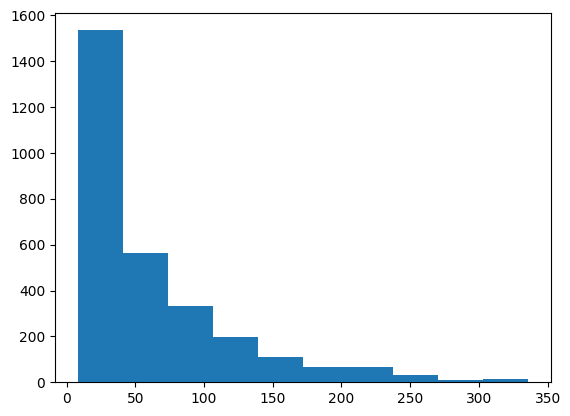

In [34]:
plt.hist(lengths)